# Finding out the significant features
- This segment is uses a random forest to:
    1. Go through each drone folder
    2. Load the IQ from rx and bin from sweep
    3. Convert them into features using TSFEL
    4. Train a Random Forest to get important features


- All hail chatgpt


In [5]:
import os
import glob
import numpy as np
import pandas as pd
import tsfel

# --- Configuration ---
folder_path = r"C:\Users\aksha\OneDrive\VSC\VSC\Work\DroneResearch\data\output\DatasetCollection_Scis2Outdoors_210825"
cfg = tsfel.get_features_by_domain()  # all TSFEL features

# --- Helper function to load .ifft files ---
def load_ifft(path):
    dtypes_to_try = [np.float32, np.float64, np.complex64, np.complex128]
    for dt in dtypes_to_try:
        try:
            data = np.fromfile(path, dtype=dt)
            if data.size > 0:
                return data, dt
        except:
            continue
    raise ValueError(f"Could not interpret {path}")

# --- Load files ---
file_paths = glob.glob(os.path.join(folder_path, "*", "sweep", "*.ifft"))

features_list = []
labels = []
file_paths_clean = []

for path in file_paths:
    try:
        data, _ = load_ifft(path)
        signal = np.abs(data) if np.iscomplexobj(data) else data
        
        # Extract TSFEL features
        feat_df = tsfel.time_series_features_extractor(cfg, signal, fs=1000)
        features_list.append(feat_df)
        
        # Correct label: parent folder of 'sweep'
        label = os.path.basename(os.path.dirname(os.path.dirname(path)))
        labels.append(label)
        file_paths_clean.append(path)
        
    except Exception as e:
        print(f"Skipping {path}: {e}")

# Combine features and labels
X = pd.concat(features_list, ignore_index=True)
y = pd.Series(labels, name="label")
print("Features shape:", X.shape)
print("Labels length:", len(y))

Features shape: (350, 156)
Labels length: 350


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest Training ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# --- Evaluation ---
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


                                 precision    recall  f1-score   support

  Aquila16_Ifft_100m_1_40_40_01       1.00      0.80      0.89        10
   Aquila16_Ifft_50m_1_40_40_01       0.86      0.60      0.71        10
Background_Ifft_100m_1_40_40_01       0.73      0.80      0.76        10
  DjiMini2_Ifft_100m_1_40_40_01       0.82      0.90      0.86        10
   DjiMini2_Ifft_50m_1_40_40_01       0.71      1.00      0.83        10
   DjiRcN1_Ifft_100m_1_40_40_01       0.67      0.60      0.63        10
    DjiRcN1_Ifft_50m_1_40_40_01       0.80      0.80      0.80        10

                       accuracy                           0.79        70
                      macro avg       0.80      0.79      0.78        70
                   weighted avg       0.80      0.79      0.78        70



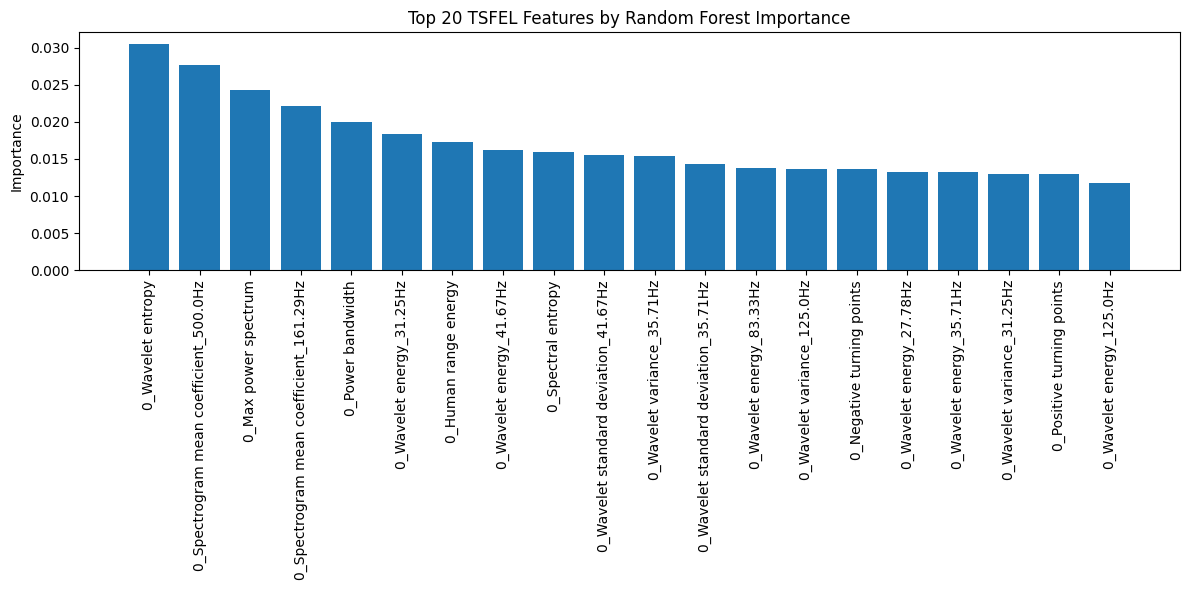

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- Feature Importance ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 features
top_n = 20
plt.figure(figsize=(12,6))
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X.columns[indices[:top_n]], rotation=90)
plt.title("Top 20 TSFEL Features by Random Forest Importance")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


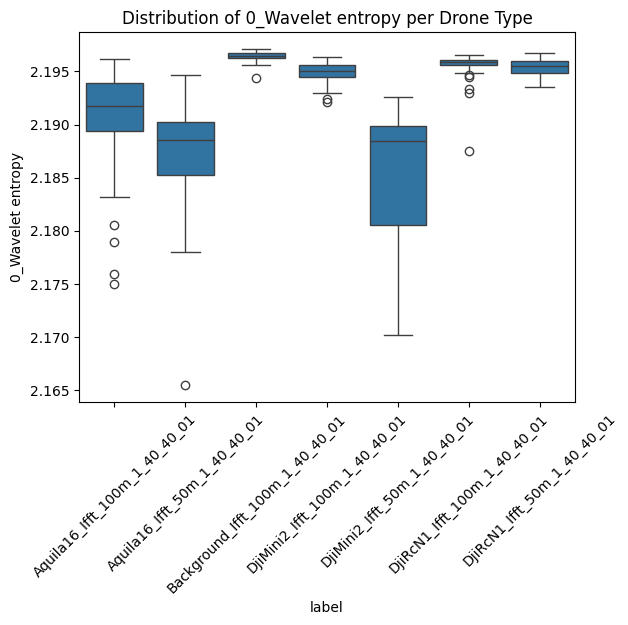

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

top_feature = '0_Wavelet entropy'
sns.boxplot(x=y, y=X[top_feature])
plt.xticks(rotation=45)
plt.title(f"Distribution of {top_feature} per Drone Type")
plt.show()


# Coding a CNN
## Ignore lol chatgpt trolling my elo ill edit

In [14]:
import os
import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Parameters
folder_path = r"C:\Users\aksha\OneDrive\VSC\VSC\Work\DroneResearch\data\output\DatasetCollection_Scis2Outdoors_210825"
fixed_length = 4096  # adjust depending on your signal length

# Load .ifft files
file_paths = glob.glob(os.path.join(folder_path, "*", "sweep", "*.ifft"))

signals = []
labels = []

def load_ifft(path):
    dtypes_to_try = [np.float32, np.float64, np.complex64, np.complex128]
    for dt in dtypes_to_try:
        try:
            data = np.fromfile(path, dtype=dt)
            if data.size > 0:
                return data
        except:
            continue
    raise ValueError(f"Could not interpret {path}")

for path in file_paths:
    try:
        data = load_ifft(path)
        signal = np.abs(data) if np.iscomplexobj(data) else data
        
        # Pad or truncate to fixed length
        if len(signal) < fixed_length:
            signal = np.pad(signal, (0, fixed_length - len(signal)))
        else:
            signal = signal[:fixed_length]
        
        signals.append(signal)
        label = os.path.basename(os.path.dirname(os.path.dirname(path)))
        labels.append(label)
    except Exception as e:
        print(f"Skipping {path}: {e}")

# Convert to numpy arrays
X = np.array(signals, dtype=np.float32)  # (num_samples, fixed_length)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_int = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_int, test_size=0.2, random_state=42, stratify=y_int
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train).unsqueeze(1)  # shape = (samples, channels=1, timesteps)
X_test = torch.tensor(X_test).unsqueeze(1)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [18]:
import torch.nn as nn
import torch.optim as optim

num_classes = len(le.classes_)

class CNN1D(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        
        # Compute the size after conv/pool layers
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            dummy = self.pool1(torch.relu(self.conv1(dummy)))
            dummy = self.pool2(torch.relu(self.conv2(dummy)))
            dummy = self.pool3(torch.relu(self.conv3(dummy)))
            flattened_size = dummy.numel()
        
        self.fc1 = nn.Linear(flattened_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = CNN1D(input_length=fixed_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {train_loss:.4f} Acc: {train_acc:.4f}")


cpu
Epoch [1/50] Loss: 1.9899 Acc: 0.1500
Epoch [2/50] Loss: 1.9615 Acc: 0.1143
Epoch [3/50] Loss: 1.9479 Acc: 0.1500


KeyboardInterrupt: 

In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")